Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

Import Data

In [2]:
df = pd.read_csv('AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-23,39.222500,39.422501,38.875000,39.042500,37.053883,87937200
1,2017-10-24,39.072498,39.355000,39.049999,39.275002,37.274548,71028800
2,2017-10-25,39.227501,39.387501,38.817501,39.102501,37.110828,84828400
3,2017-10-26,39.307499,39.457500,39.195000,39.352501,37.348103,68002000
4,2017-10-27,39.822498,40.900002,39.674999,40.762501,38.686283,177816800


``We Are Only Interested In Closing Prices And Dates, So Let's Fix That``

## EDA

In [3]:
df.shape

(1259, 7)

Dropping Irrelevant Columns

In [4]:
df.drop(["Open","High","Low", "Adj Close", "Volume"], inplace=True, axis=1)
df

,Date,Close
0,2017-10-23,39.042500
1,2017-10-24,39.275002
2,2017-10-25,39.102501
3,2017-10-26,39.352501
4,2017-10-27,40.762501
...,...,...
1254,2022-10-17,142.410004
1255,2022-10-18,143.750000
1256,2022-10-19,143.860001
1257,2022-10-20,143.389999


Making The Date Column Our Index And Normalizing Values

In [5]:
dates = df["Date"]
# Converting Dates To Numbers
normalized_dates = []
for i in dates:
    normalized_dates.append(round(((pd.to_datetime(i).year-2017)+(pd.Period(i).dayofyear/365)),3))
df_norm = pd.DataFrame(data=df["Close"].values, index=normalized_dates, columns=["Close"])
df_norm

,Close
0.811,39.042500
0.814,39.275002
0.816,39.102501
0.819,39.352501
0.822,40.762501
...,...
5.795,142.410004
5.797,143.750000
5.800,143.860001
5.803,143.389999


Plotting Data

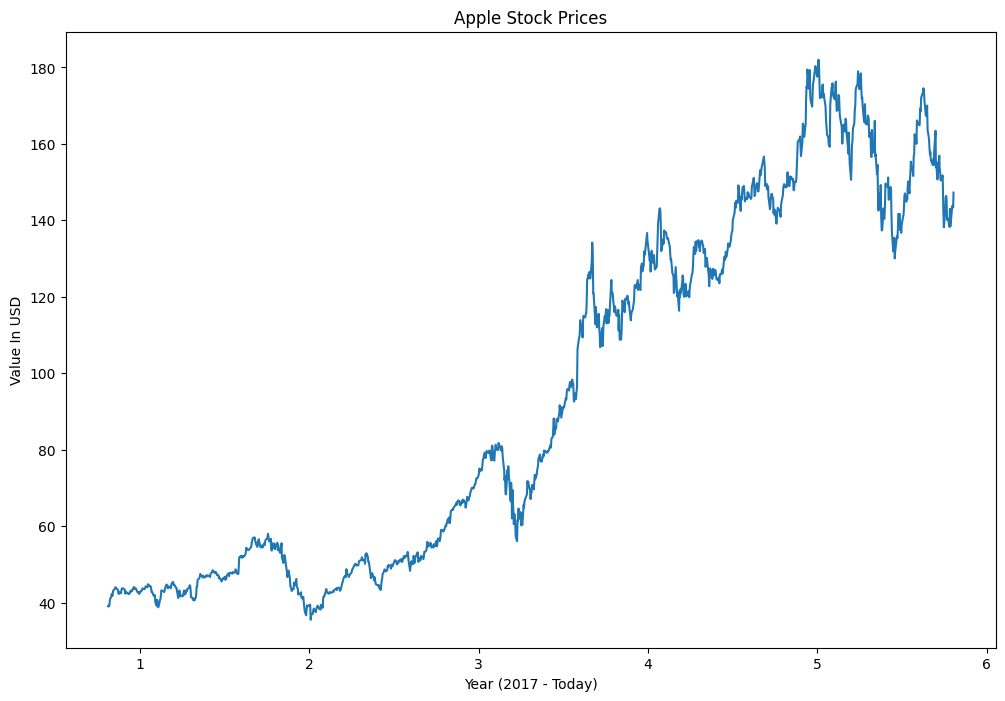

In [6]:
plt.figure(figsize=(12,8))
plt.plot(df_norm)
plt.xlabel("Year (2017 - Today)")
plt.ylabel("Value In USD")
plt.title("Apple Stock Prices")
plt.show()

Scaling Our Data, Inserting Into 

In [7]:
scaler = MinMaxScaler()
norm_close_val = scaler.fit_transform(df_norm)
norm_close_val
df_norm["Close"] = norm_close_val
num_df = np.array(norm_close_val)
df_norm

,Close
0.811,0.023863
0.814,0.025450
0.816,0.024272
0.819,0.025979
0.822,0.035606
...,...
5.795,0.729624
5.797,0.738773
5.800,0.739524
5.803,0.736315


In [8]:
import pickle

def scaler_pickling(scaler, file_name):
    import pickle
    with open(file_name, "wb") as f:
        pickle.dump(scaler, f)

In [9]:
scaler_pickling(scaler, "flask_app/website/static/byte_models/apple_scaler.pkl")

Splitting to training, testing and validation sets
train set: 0.70
test set: 0.20
val set: 0.10

In [8]:
total_len = len(num_df)-365
train_test_val = np.around([total_len * 0.7, total_len * 0.1, total_len * 0.2], decimals=0)
train_test_val = [int(i) for i in train_test_val]
train_test_val

[626, 89, 179]

train set = 626
val set = 89
test set = 179

Our Time Step Will Be 365 Days

In [9]:
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []
time_step = 365
for i in range(time_step, len(num_df)):
    # Train Set
    if i < time_step + train_test_val[0]:
        X_train.append(num_df[i-time_step:i,0])
        y_train.append(num_df[i,0])
    elif time_step + train_test_val[0] <= i < time_step + train_test_val[0] + train_test_val[1]:
        X_val.append(num_df[i-time_step:i,0])
        y_val.append(num_df[i,0])
    else:
        X_test.append(num_df[i-time_step:i,0])
        y_test.append(num_df[i,0])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)
    
        

In [10]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

626
89
179


Checking Our Shapes

In [11]:
X_train.shape

(626, 365)

We Want Our Shape To Be (x,x,1) for X
and (x,1) for y

In [12]:
# For Train Sets
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], 1)
print("X Train Shape:",X_train.shape, "| y Train Shape:", y_train.shape)


X Train Shape: (626, 365, 1) | y Train Shape: (626, 1)


In [13]:
# For val Sets
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], 1)
print("X val Shape:",X_val.shape, "| y val Shape:", y_val.shape)

X val Shape: (89, 365, 1) | y val Shape: (89, 1)


In [14]:
# For test Sets
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
print("X test Shape:",X_test.shape, "| y test Shape:", y_test.shape)

X test Shape: (179, 365, 1) | y test Shape: (179, 1)


Our Sets Are Ready Time To Set Up Our Model

In [15]:
regressor = Sequential()

regressor.add(LSTM(units=180, return_sequences=True, input_shape=(X_train.shape[1],1)))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units=365, return_sequences=True))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units=180, return_sequences=True))
# regressor.add(Dropout(0.2))
regressor.add(LSTM(units=180, return_sequences=False))
regressor.add(Dense(25))
regressor.add(Dense(1))

Compiling Using Adam

In [16]:
regressor.compile(optimizer=Adam(learning_rate=0.0026), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])

#### Summary

In [17]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 365, 180)          131040    
                                                                 
 lstm_1 (LSTM)               (None, 180)               259920    
                                                                 
 dense (Dense)               (None, 25)                4525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 395,511
Trainable params: 395,511
Non-trainable params: 0
_________________________________________________________________


Plotting Model Structure

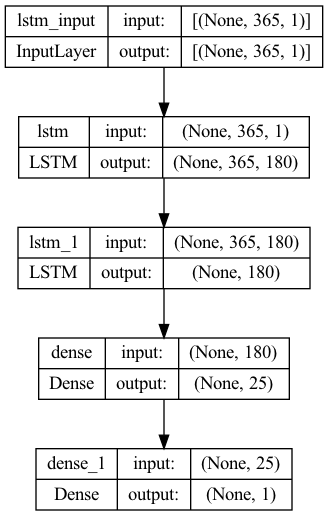

In [18]:
tf.keras.utils.plot_model(regressor, show_shapes=True)

Training The Model

In [19]:
hist = regressor.fit(X_train,
                     y_train,
                     validation_data=(X_val, y_val),
                     epochs=10)
                     #callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=0))

Epoch 1/10


2022-10-25 00:18:49.632896: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


20/20 [==============================] - 14s 604ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 2/10
20/20 [==============================] - 12s 602ms/step - loss: 9.3041e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 3/10
20/20 [==============================] - 12s 602ms/step - loss: 5.6977e-04 - root_mean_squared_error: 0.0239 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0324
Epoch 4/10
20/20 [==============================] - 12s 607ms/step - loss: 5.9411e-04 - root_mean_squared_error: 0.0244 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 5/10
20/20 [==============================] - 12s 613ms/step - loss: 7.2409e-04 - root_mean_squared_error: 0.0269 - val_loss: 9.9661e-04 - val_root_mean_squared_error: 0.0316
Epoch 6/10
20/20 [==============================] - 13s 669ms/step - loss: 9.3498e-04 - root_mean_squared_error: 0.0306 - val_

Plotting Loss Over Time

<AxesSubplot:>

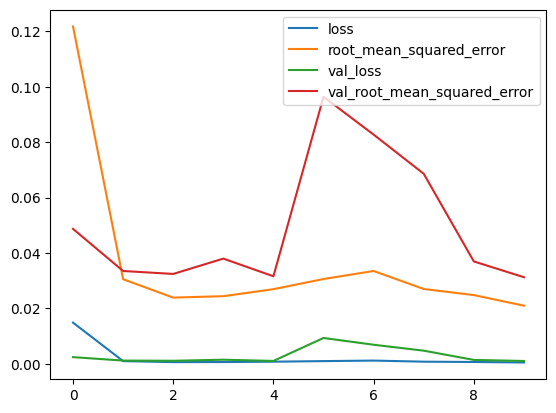

In [20]:
pd.DataFrame(hist.history).plot()

Predicting Baseline (train data)

20/20 [==============================] - 4s 197ms/step


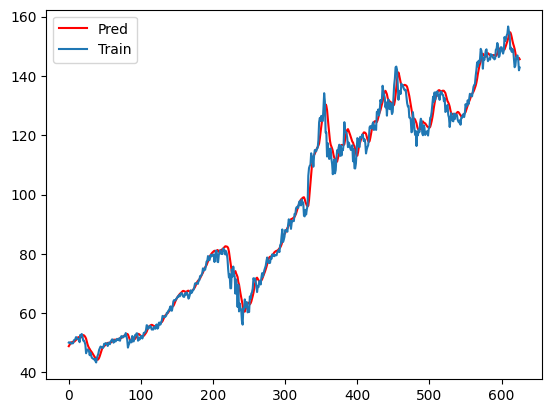

In [21]:
y_train_pred = scaler.inverse_transform(regressor.predict(X_train))
y_train_true = scaler.inverse_transform(y_train)
plt.plot(y_train_pred, 'r')
plt.plot(y_train_true)
plt.legend(["Pred","Train"])
plt.show()

Test Prediction

6/6 [==============================] - 1s 191ms/step


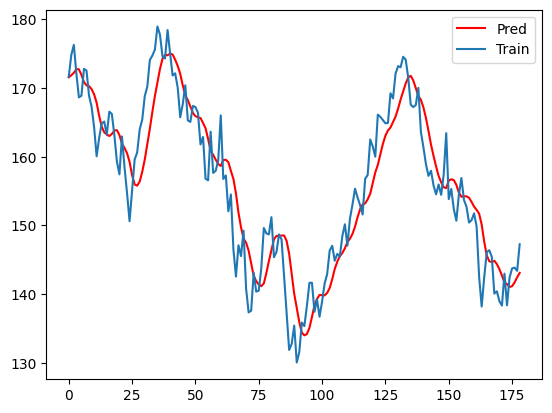

In [22]:
y_test_pred = scaler.inverse_transform(regressor.predict(X_test))
y_test_true = scaler.inverse_transform(y_test)
plt.plot(y_test_pred, 'r')
plt.plot(y_test_true)
plt.legend(["Pred","Train"])
plt.show()

R2 Score For Model

In [26]:
np.round(r2_score(y_test_true, y_test_pred),decimals=2)

0.85

85% Accuracy For The Model IS A Good Starting Point

Creating a pickled version

pickling function

In [24]:
import pickle

def file_pickling(model, file_name):
    import pickle
    with open(file_name, "wb") as f:
        pickle.dump(model, f) 

In [25]:
file_pickling(regressor, "byte_models/apple.pkl")

INFO:tensorflow:Assets written to: ram://dc864b7e-0148-45ba-a990-8c0bef0eba24/assets


INFO:tensorflow:Assets written to: ram://dc864b7e-0148-45ba-a990-8c0bef0eba24/assets
